# 2D convolution network with Adam optimizer

In [1]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import backend as K
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from PIL import Image

import numpy as np
from numpy.testing import assert_allclose, assert_equal
import matplotlib
import matplotlib.pyplot as plt
import os

# initialization and check if dataset got proper size

path = '/home/ubuntu/zdjecia_wybrane/'
# path = '/home/oziomek/licencjat/kostki/zdjecia/'
listing = os.listdir(path)
print(listing)
num_samples = 0
for folder in os.listdir(path):
    for i in range(1, 7):
        num_samples += len(os.listdir(path + folder + '/' + str(i)))
assert_equal(69552, num_samples)
print(num_samples)

Using TensorFlow backend.


['woodOnRed', 'blackOnRed', 'navyOnWhite', 'whiteOnBlue', 'greenOnWhite', 'navyOnBlue', 'hardLight', 'whiteOnRed_distance', 'whiteOnBlack', 'whiteOnRed']
69552


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# load all data into numpy array
immatrix = np.array(
    [np.array(Image.open(path + folder + '/' + str(i) + '/' + file)).flatten() 
         for folder in os.listdir(path)
             for i in range(1, 7) 
                 for file in os.listdir(path + folder + '/' + str(i))], 'f')

In [3]:
print(immatrix.shape)

(69552, 4096)


In [4]:
labels = np.ones((num_samples, ), dtype=int)
counter = 0
for folder in os.listdir(path):
    for i in range(1, 7):
        samples = len(os.listdir(path + folder + '/' + str(i)))
        labels[counter:counter+samples] = i-1
        counter += samples

In [5]:
# randomize data with const random_state
data, label = shuffle(immatrix, labels, random_state=13)

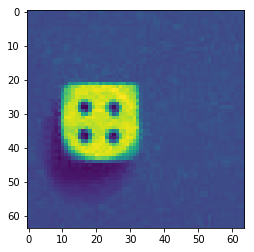

There are 4 dots, number is 1716


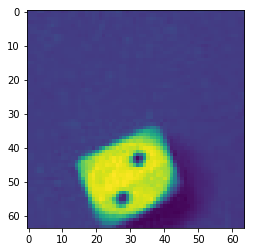

There are 2 dots, number is 698


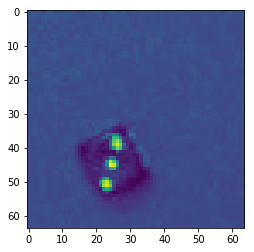

There are 3 dots, number is 6634


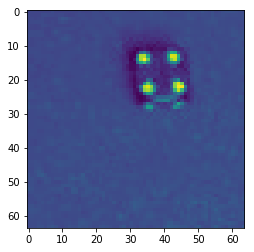

There are 4 dots, number is 8206


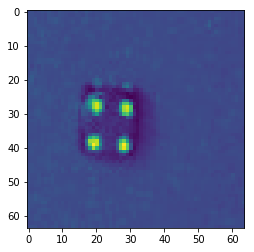

There are 4 dots, number is 9328


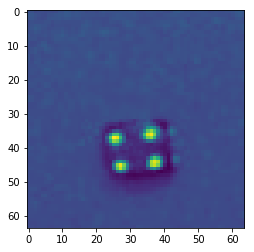

There are 4 dots, number is 8779


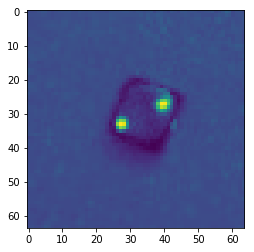

There are 2 dots, number is 5574


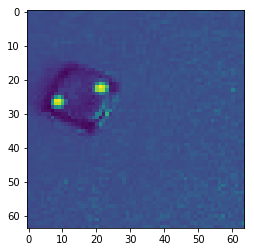

There are 2 dots, number is 5202


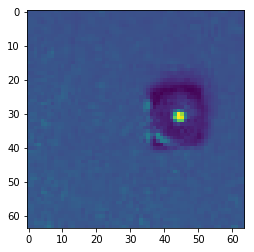

There are 1 dots, number is 3827


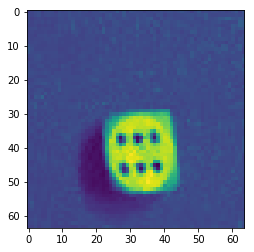

There are 6 dots, number is 2930


In [6]:
# show randomly chosen image
rows, cols = 64, 64
labels_values = 6
train_data = [data, label]
import random
for i in range(10):
    random_image = random.randint(0, 10080)
    img=immatrix[random_image].reshape(rows, cols)
    plt.imshow(img)
    plt.show()
    print("There are {} dots, number is {}".format(labels[random_image] + 1, random_image))

In [7]:
(X, y) = (train_data[0], train_data[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [8]:
# reshape to [color_layers][pixels_height][pixels_width], color_layers equal to 2 because photos are in GRAYSCALE
X_train = X_train.reshape(X_train.shape[0], 1, rows, cols).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, rows, cols).astype('float32')

# normalize to 0-1
X_train /= 255
X_test /= 255

print(X_train.shape, X_test.shape)

(55641, 1, 64, 64) (13911, 1, 64, 64)


In [9]:
# onehot
y_train = to_categorical(y_train, 6)
y_test = to_categorical(y_test, 6)
print(y_train.shape, y_test.shape)

(55641, 6) (13911, 6)


In [10]:
# create sequential model with 2NN layers
def base_model():
    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=(1, 64, 64), data_format='channels_first', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (5, 5), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(784, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(196, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(labels_values, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
# summarize model and apply checkpoints
model = base_model()
print(model.summary())
filepath = 'model3adam-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 60, 60)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 30, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 26, 32)        48032     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 26, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23296)             0         
_______________________________________________________

In [12]:
# visualization of a model
plot_model(model, to_file='model3adam_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=2048, verbose=1, callbacks=callbacks_list)

Train on 55641 samples, validate on 13911 samples
Epoch 1/25
55641/55641 [==============================] - 26s 470us/step - loss: 1.7930 - acc: 0.1742 - val_loss: 1.7897 - val_acc: 0.1786
Epoch 2/25
55641/55641 [==============================] - 22s 396us/step - loss: 1.7673 - acc: 0.2053 - val_loss: 1.6831 - val_acc: 0.2653
Epoch 3/25
55641/55641 [==============================] - 22s 399us/step - loss: 1.5824 - acc: 0.2969 - val_loss: 1.3919 - val_acc: 0.4102
Epoch 4/25
55641/55641 [==============================] - 22s 402us/step - loss: 1.3556 - acc: 0.4050 - val_loss: 1.2534 - val_acc: 0.4668
Epoch 5/25
55641/55641 [==============================] - 22s 403us/step - loss: 1.2224 - acc: 0.4732 - val_loss: 1.0968 - val_acc: 0.5447
Epoch 6/25
55641/55641 [==============================] - 22s 402us/step - loss: 1.1369 - acc: 0.5077 - val_loss: 1.0191 - val_acc: 0.5715
Epoch 7/25
55641/55641 [==============================] - 22s 404us/step - loss: 1.0263 - acc: 0.5582 - val_loss: 1.

In [14]:
score = model.evaluate(X_test, y_test, verbose=1)

13911/13911 [==============================] - 3s 201us/step


In [15]:
print(history.history.keys())
print("Accuracy: %.2f%%" % (score[1]*100))
print('Test loss:', score[0])
print('Test accuracy', score[1])

dict_keys(['loss', 'val_acc', 'acc', 'val_loss'])
Accuracy: 89.24%
Test loss: 0.2645845416999979
Test accuracy 0.8923873193746809


In [16]:
print('training results:')
for i in range(len(model.metrics_names)):
    print(str(model.metrics_names[i]) + ": " + str(score[i]))

training results:
loss: 0.2645845416999979
acc: 0.8923873193746809


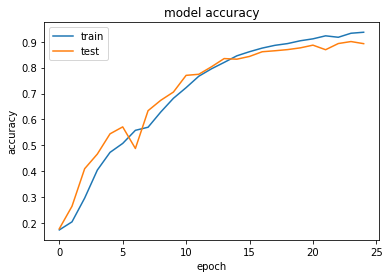

In [17]:
#summarize for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

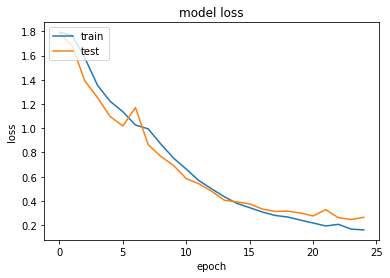

In [18]:
#summarize for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
model_json = model.to_json()
with open('model3adam_model.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('model3adam_weights.h5')
print('Saved model weights')

Saved model weights


In [ ]:
new_model = load_model('model3adam-25-1.0456.h5')
# check in models are similar to the given tolerance
assert_allclose(model.predict(X_train),
               new_model.predict(X_train),
               1e-4)

In [ ]:
filepath = 'model3adam_continue-{epoch:02d}-{loss:.4f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
new_history = new_model.fit(X_train, y_train, epochs=10, batch_size=2048, callbacks=callbacks_list)

In [ ]:
new_score = new_model.evaluate(X_test, y_test, verbose=1)
print('training results:')
for i in range(len(new_model.metrics_names)):
    print(str(new_model.metrics_names[i]) + ": " + str(new_score[i]))

In [ ]:
plt.plot(new_history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(new_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_json = model.to_json()
with open('model3adam_continue.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('model3adam_weights_continue.h5')
print('Saved model weights')